**Purpose of this this notebook:** Sentiment analysis just for review dataset.

In [1]:
#Mount my Google Drive.
from google.colab import drive
drive.mount("/content/drive")
import os
directory = '/content/drive/My Drive/DSC 672'
os.chdir(directory)

#Ensure the files are there (in the folder).
!pwd

Mounted at /content/drive
/content/drive/My Drive/DSC 672


In [2]:
import pandas as pd
import ast

#Sentiment analysis.
!pip install -q nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
#Lemmatization.
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#Ngrams.
from nltk.util import ngrams

#For plotting.
!pip install -q matplotlib
!pip install -q wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

#For warnings.
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Load Data.**
*   Using cleaned data from previous update.
*   Note: Since the 'review_scores_ratings' data initially comes with the dataset is extremely skewed. Out of 7,952 listings, there is only 167 listings has < 4.0 rating score, on a 1 to 5 scale. Thus, we will validate preliminary sentiment analysis through Word cloud.

In [ ]:
reviews = pd.read_csv("reviews_final.csv")
print (f"Reviews dataset shape: {reviews.shape}")
#Convert string representations of lists into actual lists.
reviews['comments_tokenized'] = reviews['comments_tokenized'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
reviews.head(2)

Reviews dataset shape: (403291, 6)


,listing_id,id,date,comments,reviews_length,comments_tokenized
0,2384,25218143,1/9/2015,it's a wonderful trip experience. I didn't exc...,46,"[wonderful, trip, experience, except, bedroom,..."
1,2384,28475392,3/24/2015,This is my first trip using Airbnb. I was a li...,106,"[first, trip, using, airbnb, little, nervous, ..."


# **Data Pre-process.**

In [ ]:
#Get number of unique tokens per reviews pre lemmatization.
reviews['unique_token_count_pre_lemma'] = reviews['comments_tokenized'].apply(lambda x: len(set(x)))

## **Apply lemmatization -> Reduce a word to its root form.**

In [ ]:
#Initialize the lemmatizer.
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
  '''Lemmatize tokens'''
  return [lemmatizer.lemmatize(token) for token in tokens]

#Apply lemmatization on tokenied column.
reviews['comments_lemmatized'] = reviews['comments_tokenized'].apply(lemmatize_tokens)
#Get number of unique tokens per reviews post lemmatization.
reviews['unique_token_count_post_lemma'] = reviews['comments_lemmatized'].apply(lambda x: len(set(x)))

In [ ]:
#Get number of rows where the unique token counts differ before and after lemmatization.
countDiff = (reviews['unique_token_count_pre_lemma'] != reviews['unique_token_count_post_lemma']).sum()
print(f"Number of rows with different unique token counts pre and post lemmatization: {countDiff}")

Number of rows with different unique token counts pre and post lemmatization: 31103


## **Generate trigram -> Kind of redundant but do it anyway. We will apply ngram differently later.**

In [ ]:
def generateTrigrams(tokens):
  '''Generate trigrams from a list of tokens.'''
  return list(ngrams(tokens, 3))

reviews['trigrams'] = reviews['comments_lemmatized'].apply(generateTrigrams)

## **Get top token count.**

In [ ]:
def get_topTokens(data, columnName='comments_lemmatized', k=10):
  '''Get top k token in a lemma-tokenize column.'''

  #Flatten the tokenized reviews into a single list.
  allTokens = [word for tokens in data[columnName] for word in tokens]

  #Create a dictionary with word counts using Counter.
  word_countDict = Counter(allTokens)

  #Sort the dictionary by frequency in descending order.
  sorted_wordCount = dict(sorted(word_countDict.items(), key=lambda item: item[1], reverse=True))

  #Return the top N words and their frequencies.
  return {k: sorted_wordCount[k] for k in list(sorted_wordCount)[:k]}

In [ ]:
topWords = get_topTokens(reviews, columnName='comments_lemmatized', k=10)
print(topWords)

{'great': 259544, 'place': 233850, 'stay': 213206, 'location': 138990, 'clean': 114953, 'host': 107422, 'would': 97549, 'chicago': 87009, 'nice': 78476, 'apartment': 72600}


In [ ]:
def filter_shortTokens(tokens):
  '''remove token with length <= 1.'''
  #Common words.
  customStopwords = set(['stay', 'place', 'chicago', 'host', 'room', 'airbnb'])
  #1 len to remove punctuations, stand alone strings like 'a', 'e'.
  return [token for token in tokens if len(token) > 1 and token.lower() not in customStopwords]

reviews['comments_lemmatized'] = reviews['comments_lemmatized'].apply(filter_shortTokens)

In [ ]:
topWords = get_topTokens(reviews, columnName='comments_lemmatized', k=10)
print(topWords)

{'great': 259544, 'location': 138990, 'clean': 114953, 'would': 97549, 'nice': 78476, 'apartment': 72600, 'comfortable': 69376, 'easy': 66570, 'everything': 64105, 'recommend': 62007}


# **Sentiment analysis on raw reviews string.**

In [ ]:
#Initialize VADER sentiment analyzer.
sia = SentimentIntensityAnalyzer()

#Apply VADER to the 'comments' column and get the compound score.
reviews['vader_compound_score'] = reviews['comments'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [ ]:
def classifySentiment(compound):
  '''Classify sentiment based on the compound score.'''
  #Significant amount of positive reviews in this dataset.
  if compound >= 0.5:
    return 'positive'
  #As soon as compound is negative, deemed as negative
  elif compound < 0:
    return 'negative'
  else:
    return 'neutral'

reviews['VADER_sentiment'] = reviews['vader_compound_score'].apply(classifySentiment)

In [ ]:
#Class imbalance -- VADER --.
reviews['VADER_sentiment'].value_counts()

,count
VADER_sentiment,
positive,370198
neutral,26449
negative,6644


# **Word Cloud map.**

In [ ]:
def sentimentTokens(data, sentiment):
  '''Flatten tokens and join them into a single string for word cloud generation.'''

  #Filter tokenized reviews by sentiment and flatten.
  tokens = [token for tokens in data[data['VADER_sentiment'] == sentiment]['comments_lemmatized'] for token in tokens]
  return " ".join(tokens)

positiveReviews = sentimentTokens(reviews, 'positive')
neutralReviews = sentimentTokens(reviews, 'neutral')
negativeReviews = sentimentTokens(reviews, 'negative')

def generateWordcloud(text, title):
  '''Generate and display a word cloud.'''
  wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title, fontsize=18)
  plt.axis('off')
  plt.show()

**Positive reviews has the most count. Overall, we can see typical positive reviews phrases such as "highly recommend", "great location", "everything needed", "easy access" and "really enjoy".**

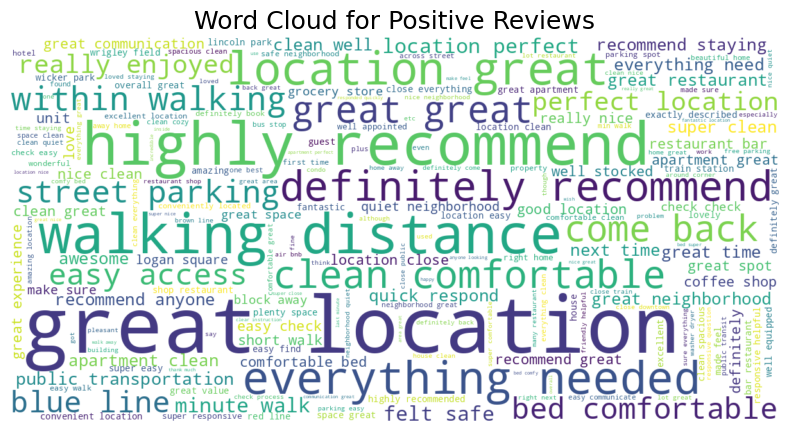

In [ ]:
generateWordcloud(positiveReviews, 'Word Cloud for Positive Reviews')

**Neutral reviews have pretty positive common descriptive words for an Airbnb like "cozy", "convenient", "need", "close", "accommodating". Yet also with negative words like "small" and "issue". The word 'good' also is more significant compared to 'great' which makes sense in terms of saticfaction for positive and neutral.**

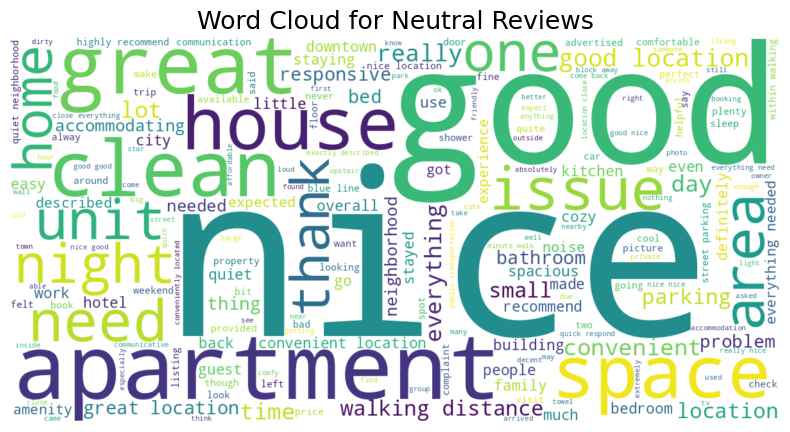

In [ ]:
generateWordcloud(neutralReviews, 'Word Cloud for Neutral Reviews')

**Negative reviews have lots of stand out negative words such as "issue", "broken", "problem". Some big word like "clean" could associate with bad adjectives. Furthermore, most likely negative reviews listings are mostly apartment unit.**

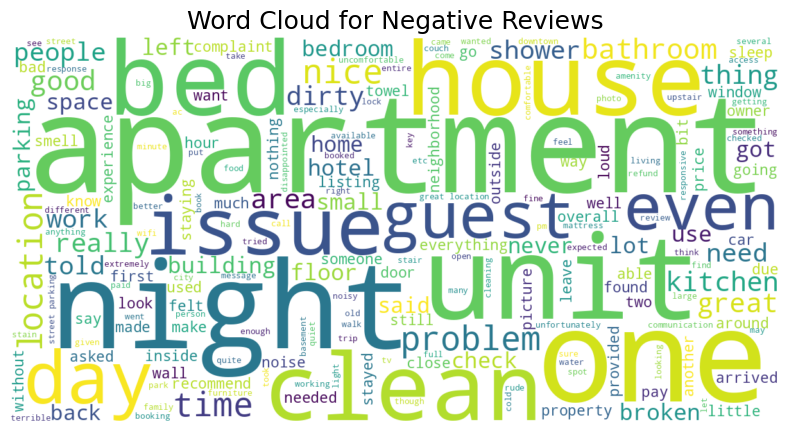

In [ ]:
generateWordcloud(negativeReviews, 'Word Cloud for Negative Reviews')

# **Train Model using VADER-label.**
#### **Logic for next step:**

*   Since the data does not comes with label. We will use Vader's output as benchmark -- Used Word cloud to verify initial sentiment output.
*   Further train and test using Logistic Regression, SVM, and Naive Bayes to cross check with Vader's output - using SMOTE and class_weight='balanced' to tackle class imbalance.
*   Apply Trigrams to better understand the contextual relationship.
*   Tried 2 ways: original comments and lemmatized comments.




In [ ]:
#Map 'sentiment' column to numerical labels.
label_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
reviews['VADER_sentiment_label'] = reviews['VADER_sentiment'].map(label_mapping)

#Some data prep.
#Join lemmatized tokens into a single string per review.
reviews['lemmatized_text'] = reviews['comments_lemmatized'].apply(lambda tokens: ' '.join(tokens))

#Define X and Y
origX = reviews['comments']
lemmaX = reviews['lemmatized_text']
Y = reviews['VADER_sentiment_label']

#Vectorize the text data.
from sklearn.feature_extraction.text import TfidfVectorizer
#Only trigrams
vectorizerOrig = TfidfVectorizer(ngram_range=(3, 3))
vectorizerLemma = TfidfVectorizer(ngram_range=(3, 3))
orig_vectorizedX = vectorizerOrig.fit_transform(origX)
lemma_vectorizedX = vectorizerLemma.fit_transform(lemmaX)

#Train-test split.
from sklearn.model_selection import train_test_split
#Original data.
orig_trainX, orig_testX, orig_trainY, orig_testY = train_test_split(orig_vectorizedX, Y, test_size=0.3, random_state=1997)
#Lemma data.
lemma_trainX, lemma_testX, lemma_trainY, lemma_testY = train_test_split(lemma_vectorizedX, Y, test_size=0.3, random_state=1997)

# **Pre-trained Models.**

## **Logistic Regression.**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time
#Initialize the model.
modelOrig_Logistic = LogisticRegression(max_iter=1000, class_weight='balanced')
modelLemma_Logistic = LogisticRegression(max_iter=1000, class_weight='balanced')

#Train on original comments.
startTime = time.time()
modelOrig_Logistic.fit(orig_trainX, orig_trainY)
#Predict and evaluate.
pred_origY_Logistic = modelOrig_Logistic.predict(orig_testX)
accuracyLogistic_Orig = accuracy_score(orig_testY, pred_origY_Logistic)
endTime = time.time()
print(f"Logistic Regression Accuracy with Original Comments (Trigrams Only): {accuracyLogistic_Orig:.2f}")
runtimeLogistic_Orig = endTime - startTime
print(f"Run time: {runtimeLogistic_Orig:.2f} seconds")

#Train on lemmatized comments.
startTime = time.time()
modelLemma_Logistic.fit(lemma_trainX, lemma_trainY)
#Predict and evaluate.
pred_lemmaY_Logistic = modelLemma_Logistic.predict(lemma_testX)
accuracyLogistic_Lemma = accuracy_score(lemma_testY, pred_lemmaY_Logistic)
endTime = time.time()
print(f"Logistic Regression Accuracy with Lemmatized Comments (Trigrams Only): {accuracyLogistic_Lemma:.2f}")
runtimeLogistic_Lemma = endTime - startTime
print(f"Run time: {runtimeLogistic_Lemma:.2f} seconds")

Logistic Regression Accuracy with Original Comments (Trigrams Only): 0.86
Run time: 362.89 seconds
Logistic Regression Accuracy with Lemmatized Comments (Trigrams Only): 0.90
Run time: 176.51 seconds


## **Linear SVC --> Regular SVC is very computationally expensive.**

In [ ]:
from sklearn.svm import LinearSVC
#Initialize the model.
modelOrig_SVC = LinearSVC(class_weight='balanced', max_iter=1000)
modelLemma_SVC = LinearSVC(class_weight='balanced', max_iter=1000)

#Train on original comments.
startTime = time.time()
modelOrig_SVC.fit(orig_trainX, orig_trainY)
pred_origY_SVC = modelOrig_SVC.predict(orig_testX)
accuracySVC_Orig = accuracy_score(orig_testY, pred_origY_SVC)
endTime = time.time()
print(f"Linear SVC Accuracy with Original Comments (Trigrams Only): {accuracySVC_Orig:.2f}")
runtimeSVC_Orig = endTime - startTime
print(f"Run time: {runtimeSVC_Orig:.2f} seconds")

#Train on lemmatized comments.
startTime = time.time()
modelLemma_SVC.fit(lemma_trainX, lemma_trainY)
pred_lemmaY_SVC = modelLemma_SVC.predict(lemma_testX)
accuracySVC_Lemma = accuracy_score(lemma_testY, pred_lemmaY_SVC)
endTime = time.time()
print(f"Linear SVC Accuracy with Lemmatized Comments (Trigrams Only): {accuracySVC_Lemma:.2f}")
runtimeSVC_Lemma = endTime - startTime
print(f"Run time: {runtimeSVC_Lemma:.2f} seconds")

Linear SVC Accuracy with Original Comments (Trigrams Only): 0.92
Run time: 66.39 seconds
Linear SVC Accuracy with Lemmatized Comments (Trigrams Only): 0.92
Run time: 107.34 seconds


## **Naive Bayes.**

In [ ]:
#Initialize the model.
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=2006)

#Train on original comments.
startTime = time.time()
orig_trainX_resampled, orig_trainY_resampled = smote.fit_resample(orig_trainX, orig_trainY)
modelOrig_NB = MultinomialNB()
modelOrig_NB.fit(orig_trainX_resampled, orig_trainY_resampled)
pred_origY_NB = modelOrig_NB.predict(orig_testX)
accuracyNB_Orig = accuracy_score(orig_testY, pred_origY_NB)
endTime = time.time()
print(f"Naive Bayes Accuracy with Original Comments (Trigrams Only): {accuracyNB_Orig:.2f}")
runtimeNB_Orig = endTime - startTime
print(f"Run time: {runtimeNB_Orig:.2f} seconds")

#Train on lemmatized comments.
startTime = time.time()
lemma_trainX_resampled, lemma_trainY_resampled = smote.fit_resample(lemma_trainX, lemma_trainY)
modelLemma_NB = MultinomialNB()
modelLemma_NB.fit(lemma_trainX_resampled, lemma_trainY_resampled)
pred_lemmaY_NB = modelLemma_NB.predict(lemma_testX)
accuracyNB_Lemma = accuracy_score(lemma_testY, pred_lemmaY_NB)
endTime = time.time()
print(f"Naive Bayes Accuracy with Lemmatized Comments (Trigrams Only): {accuracyNB_Lemma:.2f}")
runtimeNB_Lemma = endTime - startTime
print(f"Run time: {runtimeNB_Lemma:.2f} seconds")

Naive Bayes Accuracy with Original Comments (Trigrams Only): 0.89
Run time: 12.60 seconds
Naive Bayes Accuracy with Lemmatized Comments (Trigrams Only): 0.73
Run time: 11.64 seconds


## **Given the results, linear SVC on original data performs best with 92% accuracy and fastest run time. Thus, choosing this model to train on the entire data.**
*   Overall, models using lemmatize comments have longer run times compared to original full length comments.
*   We know that Vader works really week with reviews/social media text.
*   The outputs from these models are closed to Vader as well -- minimum 73% and maximum 92% of accuracy.  
*   Thus, since Vader's output are more aligned with the expectation and has slightly better class distribution, we will use Vader output for next step.




In [ ]:
results = {'Model': ['Logistic Regression', 'Logistic Regression', 'Linear SVC', 'Linear SVC', 'Naive Bayes', 'Naive Bayes'],
           'Smoothing': ['Original', 'Lemmatized', 'Original', 'Lemmatized', 'Original', 'Lemmatized'],
           'Accuracy': [accuracyLogistic_Orig, accuracyLogistic_Lemma, accuracySVC_Orig, accuracySVC_Lemma, accuracyNB_Orig, accuracyNB_Lemma],
           'Run Time': [runtimeLogistic_Orig, runtimeLogistic_Lemma, runtimeSVC_Orig, runtimeSVC_Lemma, runtimeNB_Orig, runtimeNB_Lemma]}
resData = pd.DataFrame(results)
resData

,Model,Smoothing,Accuracy,Run Time
0,Logistic Regression,Original,0.860573,362.888304
1,Logistic Regression,Lemmatized,0.896180,176.512268
2,Linear SVC,Original,0.924488,66.385745
3,Linear SVC,Lemmatized,0.918694,107.338678
4,Naive Bayes,Original,0.890915,12.595770
5,Naive Bayes,Lemmatized,0.730932,11.640194


In [ ]:
#Predict sentiment for all reviews in the dataset.
reviewsVectorized = vectorizerOrig.fit_transform(reviews['comments'])
reviews['SVC_sentiment'] = modelOrig_SVC.predict(reviewsVectorized)

In [ ]:
#Still have class imbalance issue. Keep as it is since multiple reviews belong to one listings.
reviews['SVC_sentiment'].value_counts()

,count
SVC_sentiment,
1,378720
0,19661
-1,4910


### **Spot check sentiment output differences.**
*   Manually output difference check, we can see that reviews with one word 'good' are classified as 'neutral' with 'Vader', but 'positive' with Linear SVC. Technically, 'great' should be 'positive', and 'good' should stay at neutral.



In [ ]:
mismatchedRows = reviews[(reviews['VADER_sentiment_label'] != reviews['SVC_sentiment']) & (reviews['comments'] == 'good')]
mismatchedRows [['comments', 'VADER_sentiment_label', 'SVC_sentiment']].head(2)

,comments,VADER_sentiment_label,SVC_sentiment
13479,good,0,1
30445,good,0,1


# **Write sentiment output to a csv file.**

In [ ]:
reviews = reviews.drop(columns=['reviews_length', 'comments_tokenized', 'unique_token_count_pre_lemma', 'unique_token_count_post_lemma', 'trigrams',
                                'lemmatized_text'])
reviews.head(2)

,listing_id,id,date,comments,comments_lemmatized,vader_compound_score,VADER_sentiment,VADER_sentiment_label,SVC_sentiment
0,2384,25218143,1/9/2015,it's a wonderful trip experience. I didn't exc...,"[wonderful, trip, experience, except, bedroom,...",0.9489,positive,1,1
1,2384,28475392,3/24/2015,This is my first trip using Airbnb. I was a li...,"[first, trip, using, little, nervous, trip, kn...",0.9519,positive,1,1


In [ ]:
reviews.to_csv('reviews_final2.csv', index=False)

**Export this notebook to a pdf file.**

In [3]:
!apt-get -qq install -y pandoc > /dev/null 2>&1
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert --to pdf "/content/drive/MyDrive/DSC 672/DSC672 - Review Scoring.ipynb" > /dev/null 2>&1